[【Python】金利データの取得](https://note.com/hippen/n/n45aace7102b4)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt

import yfinance as yf

# FREDから金利情報等を入手

## 金利情報

政策金利情報: [FRB Rates - discount, fed funds, primary credit](https://fred.stlouisfed.org/categories/118)
[Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FF)

- [政策金利 (Effective Federal Funds Rate)](https://fred.stlouisfed.org/categories/118): `FF`


名目・実質金利情報: [Treasury Constant Maturity](https://fred.stlouisfed.org/categories/115)

- 名目金利 (Constant Maturity Treasury, CMT) : `DGS2`, `DGS5`など`DGS`と年数のTicker名。1monthから30yearsまである。
- 実質金利 (Treasury Inflation-Indexed Security, Constant Maturity): `DFII5`, `DFII10`など`DFII`と年数のTicker名

## インフレ率

[Insterest Rate Spreads](https://fred.stlouisfed.org/categories/33446)から入手
- 期待インフレ率(Break Even Inflation Rate, BEI)
    - `T10YIE`など`T`のあとに年数。付きデータが有るときには`T20YIEM`など最後に`M`がつく
    - 物価連動国債の売買参加者が予測する今後最大10年間（物価連動国債の残存期間次第で10年未満になる場合がある）における年平均物価上昇率を示す。ここでの物価変動はコアCPIと呼ばれる「全国消費者物価指数（生鮮食品を除く総合指数）」を基準とする。[野村證券](https://www.nomura.co.jp/terms/japan/hu/A02167.html)
- (Forward Infration Rate, FIR)
    - Measures the expected inflation rate (on average) over the five-year period that begins five years from today.
- 金利差(10年名目金利-2年名目金利): `T10Y2Y`

In [160]:
table_yields = {
    "FF": "Effective Federal Funds Rate",
    "DGS1": "1-Year Constant",
    "DGS2": "2-Year Constant",
    "DGS5": "5-Year Constant",
    "DGS10": "10-Year Constant",
    "DGS30": "30-Year Constant",
    "DFII5": "5-Year Inflation-Indexed",
    "DFII10": "10-Year Inflation-Indexed",
    "DFII30": "30-Year Inflation-Indexed",
    "T5YIE": "5-Year Inflation",
    "T10YIE": "10-Year Inflation",
    "T20YIEM": "20-Year Inflation",
    "T10Y2Y": "10-Year - 2 Year",
    "CPIAUCSL" : "CPI (CPIAUCSL)",
    "CPILFESL" : "Core CPI (CPILFESL)",
    "XLB": "Materials (XLB)",
    "XLF": "Finance (XLF)",
    "XLU": "Utilty (XLU)",
    "XLE": "Energy (XLE)",
    "XLV": "Health (XLV)",
    "XME": "Metals (XME)",
    "IWD": "Value (IWD)",
    "IWF": "Growth (IWF)",

    
    "GOLD": "GOLD",
    "SLV": "SLV",
    "SPY": "SPY",
    "QQQ": "QQQ",
    "DXY": "DXY",
    
}


def defaultPlotting():
    sns.set_theme(
        rc={
            "figure.figsize": (6, 5),
            "axes.titlesize": 20,
            "axes.labelsize": 20,
            "font.size": 20,
            "legend.fontsize": 16,
        },
        style="white",
    )
    sns.set_style("whitegrid")


def get_stock_data(start, end, codelist):
    data = yf.download(codelist, start, end)

    #  display(data)
    return data["Adj Close"]  # Adjusted Close (配当込み，分割調整値)


def plot(df, xlim=None, ylim=None, ylabel="", normalize=False):
    if normalize == True:
        if xlim == None:
            df = df.apply(lambda x: x / x[0])
        else:
            df = df[xlim[0]: xlim[1]].dropna().apply(lambda x: x / x[0])

    df = df.rename(columns=table_yields)

    ax = df.plot(
        figsize=(10, 3.5), fontsize=15, linewidth=1.5, alpha=0.8, xlim=xlim, ylim=ylim
    )
    plt.legend(fontsize=10)
    #    plt.title("Yields", fontsize=45)

    plt.axhline(y=0, color="gray", linewidth=2)
    plt.xlabel("")
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(rotation=90)
#    plt.minorticks_on()
    plt.grid(which="major", ls="-")
    plt.grid(which="minor", ls="dashed")

    plt.axvline(x="2013-05-22", linewidth=1, color="b", ls="--", alpha=0.8)
    plt.axvline(x="2013-06-19", linewidth=1, color="b", ls="--", alpha=0.8)

    plt.axvline(x="2014-01-01", linewidth=1, color="r", ls="--", alpha=0.8)
    plt.axvline(x="2014-10-29", linewidth=1, color="r", ls="--", alpha=0.8)
    plt.fill_between(
        ["2014-01-01", "2014-10-29"], [ylim[1], ylim[1]], color="red", alpha=0.05
    )

    plt.axvline(x="2015-12-15", linewidth=1, color="g", ls="-", alpha=0.8)
    
    plt.show()

    

def plot_pl(df, xlim=None, ylim=None, ylabel="", normalize=False):
    if normalize == True:
        if xlim == None:
            df = df.apply(lambda x: x / x[0])
        else:
            df = df[xlim[0]: xlim[1]].dropna().apply(lambda x: x / x[0])

    cols = df.columns
    df = df.reset_index()

    dat = pd.melt(df, id_vars=["index"], value_vars=cols)
    display(dat)
    fig = px.line(dat, x="index", y="value", color="variable")
    fig.show()

def plot_alt(df, xlim=None, ylim=None, ylabel="", normalize=False):
    if normalize == True:
        if xlim == None:
            df = df.apply(lambda x: x / x[0])
        else:
            df = df[xlim[0]: xlim[1]].dropna().apply(lambda x: x / x[0])

    cols = df.columns
    df = df.reset_index()

    dat = pd.melt(df, id_vars=["index"], value_vars=cols).dropna()
    display(dat.head())
    print(dat.dtypes)
    
    alt.Chart(dat).mark_line().encode(
        x="index",
        y="value",
        color="variable"
    ).properties(
        height=300, width=500
    )


In [127]:
# start = datetime.date.today() - datetime.timedelta(days=1000)
start = datetime.date(2001, 1, 1)
end = datetime.date.today()

In [77]:
yields = ["FF", "DGS2", "DGS5", "DGS10", "DGS30", "DFII5", "DFII10", "DFII30", 
          "T10Y2Y","T5YIE"]

df_yields = web.DataReader(yields, "fred", start, end)
df_yields = df_yields.fillna(method="ffill")

### get CPI
CPI=["CPIAUCSL", "CPILFESL"]
df_cpi = web.DataReader(CPI, "fred", start, end)
df_cpi = df_cpi.fillna(method="ffill")
df_cpi=df_cpi.pct_change(12)*100

In [155]:
index = ["SPY", "QQQ", "TLT", "EDV","SHY","VTV","DXY"]
sectors =  ["XLB","XLF", "XLE","XLU", "XME", "XLV"]
commodities = ["GC=F", "SLV", "GDX", "GDXJ", "USO"]
value_grwth=["IWD","IWF"]

tickers=index+sectors+commodities+value_grwth
df_stocks = get_stock_data(
    start,
    end,
    tickers
)

[*********************100%***********************]  20 of 20 completed


In [157]:
df=pd.concat([df_yields,df_stocks],axis=1)

Yosshiさんの真似をして2013年から2018金利の推移のグラフを作ってみました。
- 上のグラフが金利(政策金利, 2年,10年,30年，金利差(10年-2年))
- 2013/5/22(青破線) バーナンキ発言(テーパリング示唆)
- 2013/6/19(青破線) FOMC(テーパリング発表)
- 2014/1/1-2014/10(薄赤領域) テーパリング期間

わかること
- テーバリング示唆で金利上昇。
- テーパリング開始後は短期金利以外は下がっている。
- 2016年からの政策金利引き上げでも長期金利は一旦下がる。(半年以上!)

下にある図はSPY, QQQ, TLT, SHY, XLF, EDVの値動きです。

わかること
- SPY, QQQは凸凹はあるもののテーパリング期間はちゃんと上昇している。
- 政策金利の引き上げ後に，SPY,QQQの大きな下げがあった。(少し前にもあった)
- XLFとSPYは政策金利引き上げ前はあまり変わらない。引き上げ後にXLFはのびているが，このとき金利差が必ずしも大きくなっているわけではない。
- 国債ETF(TLT,EDV)は，テーパリング示唆の後に底をつけて上がり始めた。
- 短期国債ETF(SHY)は，ほぼ一直線。よく見るとじわりと上がっています。

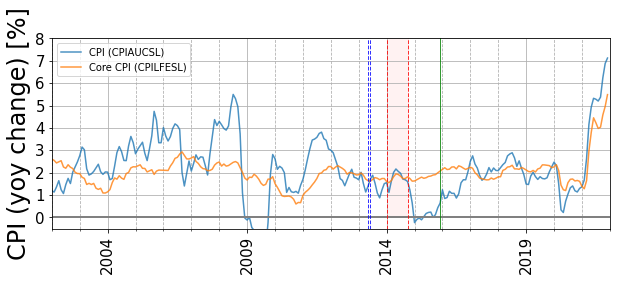

In [161]:
xlim = ["2002-01-01", "2022-01-14"]
plot(df_cpi, xlim=xlim, ylim=[-.5,8], ylabel="CPI (yoy change) [%]")

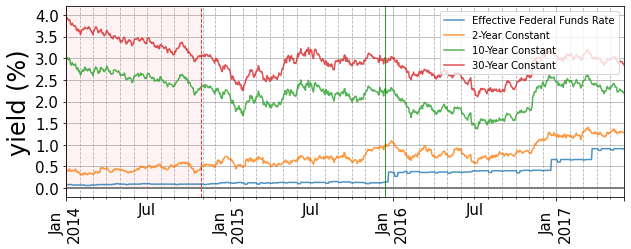

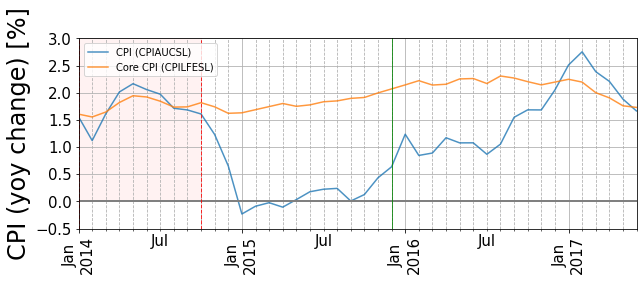

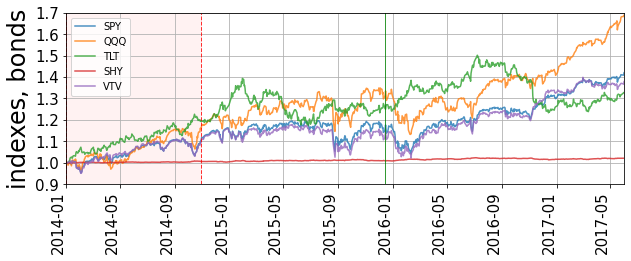

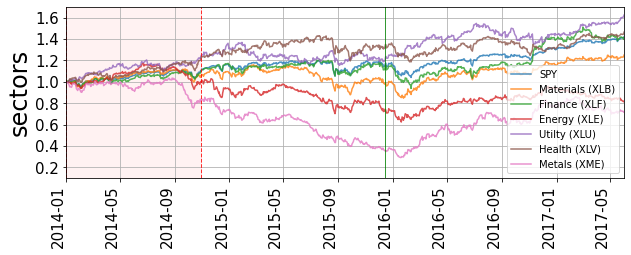

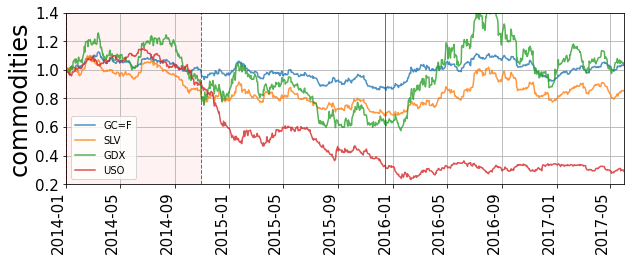

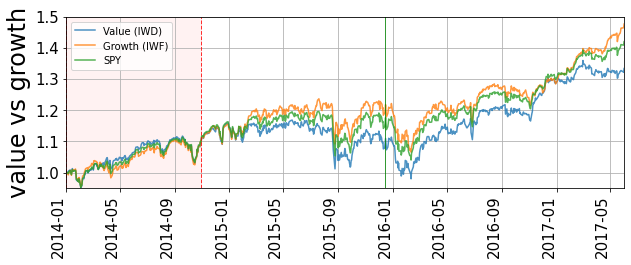

In [170]:
ytargets = ["FF", "DGS2", "DGS10", "DGS30"]
itargets = ["DFII10","DFII30","T5YIE"]
CPI = [ "CPIAUCSL", "CPILFESL" ]

index = ["SPY", "QQQ", "TLT", "SHY","VTV"]#,"DXY","EDV",
sectors =  ["SPY","XLB","XLF", "XLE","XLU", "XLV", "XME"]#, "XME"]
commodities = ["GC=F", "SLV", "GDX", "USO"]
value_grwth=["IWD","IWF", "SPY"]
xlim = ["2014-01-01", "2017-06-01"]

plot(df[ytargets], xlim=xlim, ylim=[-0.2, 4.2], ylabel="yield (%)")
#plot(df[itargets], xlim=xlim, ylim=[-.2, 3], ylabel="yield (%)")
plot(df_cpi, xlim=xlim, ylim=[-.5,3], ylabel="CPI (yoy change) [%]")

plot(df[index], xlim=xlim, ylim=[0.9, 1.7], ylabel="indexes, bonds", normalize=True)
plot(df[sectors], xlim=xlim, ylim=[0.1, 1.7], ylabel="sectors", normalize=True)

plot(df[commodities], xlim=xlim, ylim=[0.2, 1.4], ylabel="commodities", normalize=True)
plot(df[value_grwth], xlim=xlim, ylim=[0.95, 1.5], ylabel="value vs growth", normalize=True)

テーパリング開始から2年半を切り取って拡大しました。

- テーパリング期間もっとも成績が良いのは，SPYでもQQQでもなく，TLTやEDVなどの国債ETF(僕はTLTではなくEDVを買ってます)
- SPYやQQQと，国債ETF(TLT,EDV)が短期的には逆相関していることも，よく分かります。

ただ，今の長期金利は2014年頃と比べて低いので，今度のテーパリング時も国債ETFが良いかはよくわからない

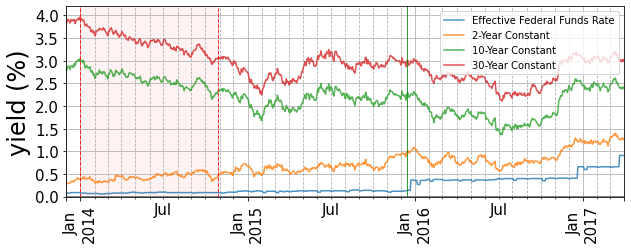

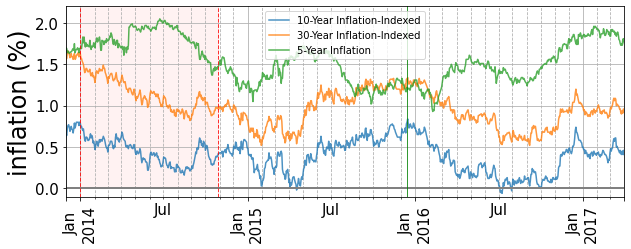

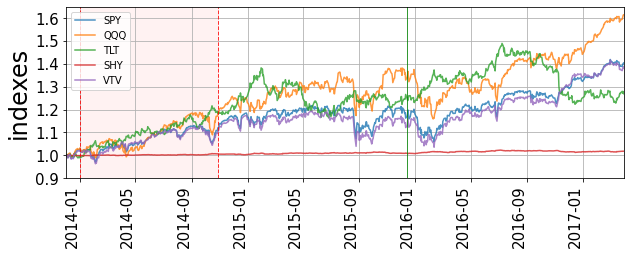

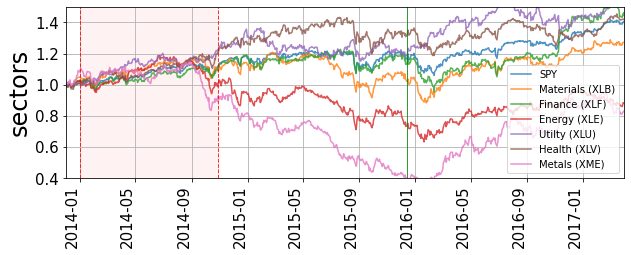

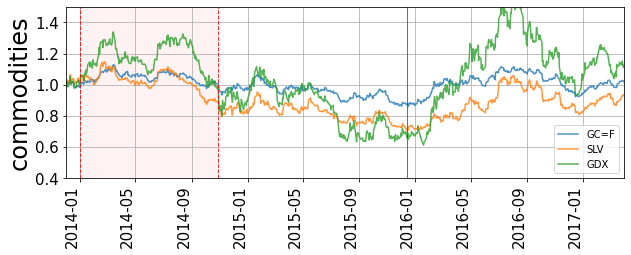

In [139]:
xlim=["2013-12-01", "2017-3-31"]
plot(df[ytargets],xlim=xlim,ylim=[0,4.2], ylabel="yield (%)")
plot(df[itargets], xlim=xlim, ylim=[-0.1, 2.2], ylabel="inflation (%)")
plot(df[index],xlim=xlim,ylim=[0.9,1.65], ylabel="indexes", normalize=True)
plot(df[sectors],xlim=xlim,ylim=[0.4,1.5], ylabel="sectors", normalize=True)
plot(df[commodities],xlim=xlim,ylim=[0.4,1.5], ylabel="commodities", normalize=True)

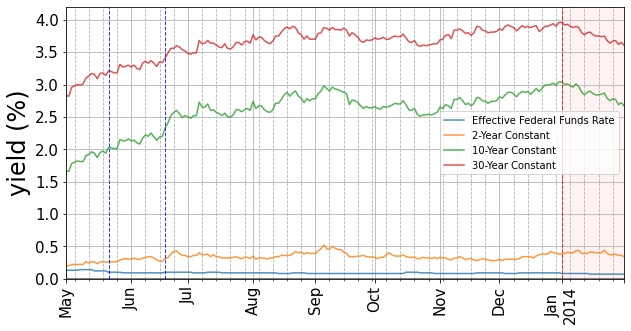

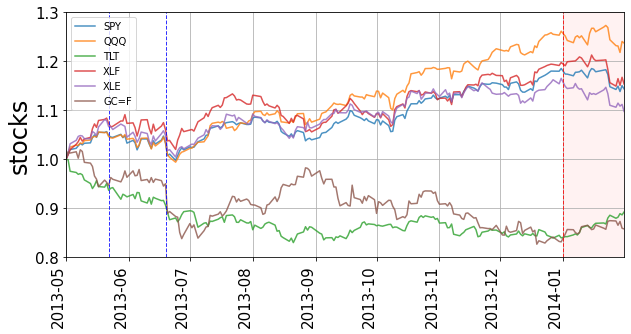

In [23]:
stargets = ["SPY", "QQQ", "TLT", "XLF", "XLE","GC=F"]

xlim=["2013-05-01", "2014-01-31"]
plot(df[ytargets],xlim=xlim,ylim=[0,4.2], ylabel="yield (%)")
#plot(df[itargets], xlim=xlim, ylim=[-0.1, 2.2], ylabel="yield (%)")
plot(df[stargets],xlim=xlim,ylim=[0.8,1.3], ylabel="stocks", normalize=True)
#plot(df[ctargets],xlim=xlim,ylim=[0.4,1.2], ylabel="stocks", normalize=True)

2013年のテーパリング発表から実際にテーパリングが始まるまでの期間(2013/05/1-2014/01/31)の値動きです。

- 長期国債ETF(TLT,EDV)はテーパリング示唆から下げ始め，その後停滞。(先週のレポート通り，テーパリング開始後は上がった)
- XLE, XLF, SPYは同程度。XLFはボラティリティやや高め
- QQQは強かった(先週のレポート通り，テーパリング開始後はちょいと弱くなっていた)
- 金(GC=F)は凸凹しながら下げ傾向

今と似ているのは2013/06-07付近か，それとも2013/10月付近かなぁ。

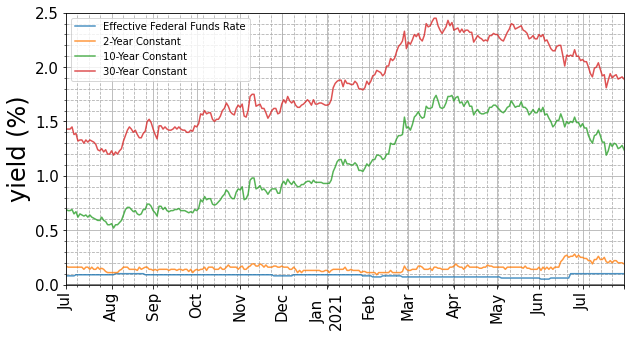

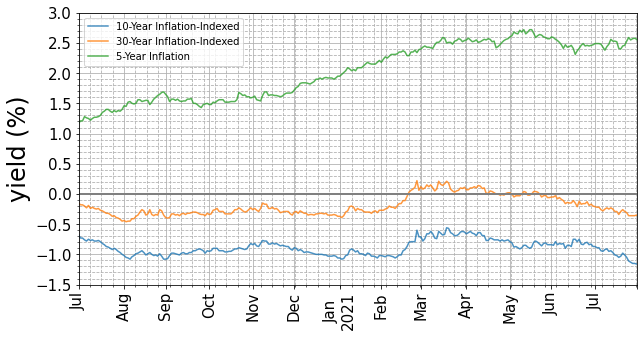

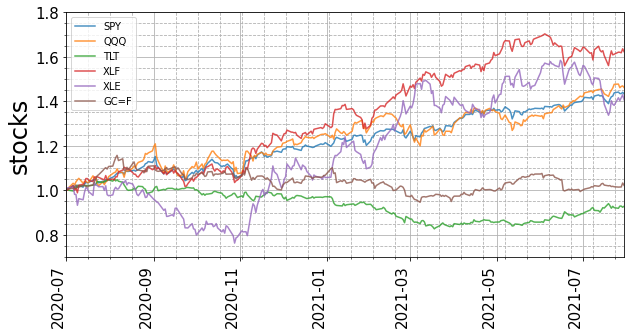

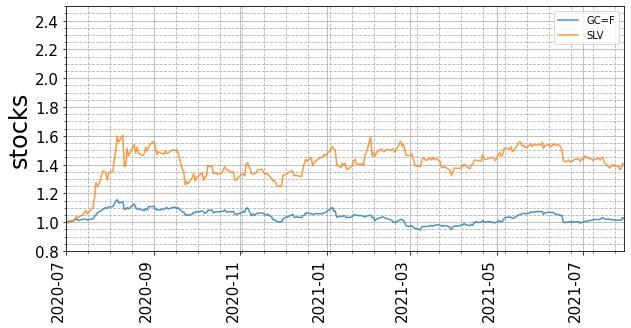

In [10]:
xlim = ["2020-07-01", "2021-07-30"]
plot(df[ytargets], xlim=xlim, ylim=[0, 2.5], ylabel="yield (%)")
plot(df[itargets], xlim=xlim, ylim=[-1.5, 3.0], ylabel="yield (%)")
plot(df[stargets], xlim=xlim, ylim=[0.7, 1.8], ylabel="stocks", normalize=True)
plot(df[ctargets], xlim=xlim, ylim=[0.8, 2.5], ylabel="stocks", normalize=True)